In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import scipy

from pydmd import DMDc
from locomotion.envs.gym_envs import A1GymEnv

In [4]:
# Simulating without substracting the mean and the standard deviation, without adding 0 mean gaussian noise

dmdc = DMDc(svd_rank=-1)

def equation_error(model, states, actions):
    loss = 0
    eigs = np.power(model.eigs, model.dmd_time["dt"] // model.original_time["dt"])
    A = np.linalg.multi_dot([model.modes, np.diag(eigs), np.linalg.pinv(model.modes)])
    for i, action in enumerate(actions):
        pred_state = A.dot(states[i]) + model._B.dot(action)
        loss = loss + np.sum((pred_state.real - states[i])**2, dtype=np.float64)
    return loss/i

def simulation_error(model, state, actions):
    loss = 0
    eigs = np.power(model.eigs, model.dmd_time["dt"] // model.original_time["dt"])
    A = np.linalg.multi_dot([model.modes, np.diag(eigs), np.linalg.pinv(model.modes)])
    for i, action in enumerate(actions):
        pred_state = A.dot(state) + model._B.dot(action)
        loss = loss + np.sum((pred_state.real - state)**2, dtype=np.float64)
        state = pred_state.real
    return loss/i

val_states = np.load("./data/pred_state.npy")
val_actions = np.load("./data/pred_action.npy")

env = A1GymEnv(action_limit=(0.75, 0.75, 0.75), render=False, on_rack=False)
T = 100
batches = 10
val = 10
e_loss = []
s_loss = []

st = env.reset()
states = [st]
actions = []
for t in tqdm(range(T)):
    at = env.action_space.sample()
    st, reward, done, info = env.step(at)
    states.append(st)
    actions.append(at)
    if t and t % batches==0:
        dmdc.fit(np.array(states[-batches-1:]).T, np.array(actions[-batches-1:-1]).T)

    if t and t % val==0:
        e_loss.append(equation_error(dmdc, val_states, val_actions))
        # s_loss.append(simulation_error(dmdc, val_states[0], val_actions))

env.close()

100%|██████████| 100/100 [00:00<00:00, 114.31it/s]


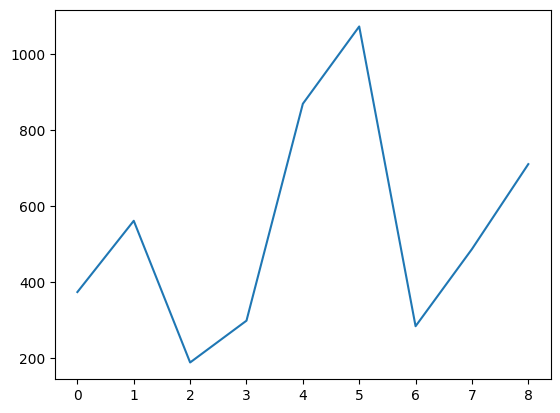

In [5]:
plt.plot(e_loss)

In [ ]:
plt.plot(s_loss)